In [1]:
import itertools
import sys,os
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.2, rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

In [4]:
import mdtraj as md

In [5]:
def unit_normal_vector(v1, v2):
    """Calculates the unit normal vector to a plane defined by two vectors.

    Args:
        v1: The first vector defining the plane.
        v2: The second vector defining the plane.

    Returns:
        The unit normal vector to the plane.
    """

    normal = np.cross(v1, v2, axisa=1)
    norm = np.linalg.norm(normal, axis=1).reshape(np.shape(normal)[0],1)
    normal = normal / norm
    return normal

# GSY

In [6]:
xtc = "../data/soup_XXL_amber99sb-star-ildn_tip3p_dense_npt_proc.xtc"
gro = "../data/soup_XXL_amber99sb-star-ildn_tip3p_dense_npt_berendsen.gro"
traj = md.load_xtc(xtc, top=gro, stride=20)

In [7]:
traj.time[-1]

894400.0

In [8]:
traj.n_frames

2237

In [9]:
GLY = [x.index for x in list(traj.topology.residues) \
       if (x.name=='GLY')] 
SER = [x.index for x in list(traj.topology.residues) \
       if (x.name=='SER')] 
TYR = [x.index for x in list(traj.topology.residues) \
       if (x.name=='TYR')]

nres = np.array([len(GLY), len(SER), len(TYR)])

## Contacts

In [10]:
ib = 100
# Find contacts for residue pairs 
# 0: Gly; 1: Ser; 2: Tyr
contact_map = {}
contact_map[0] = {}; contact_map[1] = {}; contact_map[2] = {}

contact_map[0][0] = md.compute_contacts(traj[ib:], \
                    contacts=list(itertools.combinations(GLY, 2)))    
contact_map[1][1] = md.compute_contacts(traj[ib:], \
                    contacts=list(itertools.combinations(SER, 2)))
contact_map[2][2] = md.compute_contacts(traj[ib:], \
                    contacts=list(itertools.combinations(TYR, 2)))
    
contact_map[0][1] = md.compute_contacts(traj[ib:], \
                    contacts=list(itertools.product(GLY, SER)))
contact_map[0][2] = md.compute_contacts(traj[ib:], \
                    contacts=list(itertools.product(GLY, TYR)))
contact_map[1][2] = md.compute_contacts(traj[ib:], \
                    contacts=list(itertools.product(SER, TYR)))

In [11]:
rcut = 0.6

# Calculate number contacts for residue pairs 
n_cont = np.zeros((3,3), dtype=np.int64)
for k in contact_map.keys():
    for l in contact_map[k].keys():
            for m, (i,j) in enumerate(contact_map[k][l][1]):   
                n_cont[k,l] += sum(contact_map[k][l][0][:,m] < rcut)
            if (l != k):
                n_cont[l,k] = n_cont[k,l]
lsim = len(traj[ib:]) # normalize by simulation length
n_contacts = np.int64(n_cont/lsim)

# Calculate normalized number contacts for residue pairs 
n_contacts_norm = np.sum(n_cont, axis=0)/nres/lsim

# Calculate fraction of contacts for residue pairs
# Divides number of contacts by number of pairs for each specific type
f_contacts = np.zeros((3,3), dtype=np.float64)
for k in contact_map.keys():
    for l in contact_map[k].keys():
        f_contacts[k,l] = n_cont[k,l]/(len(contact_map[k][l][1]))
        if (l != k):
            f_contacts[l,k] = f_contacts[k,l]
f_contacts = f_contacts/lsim
f_contacts_norm = np.sum(f_contacts, axis=0, dtype=np.float64)

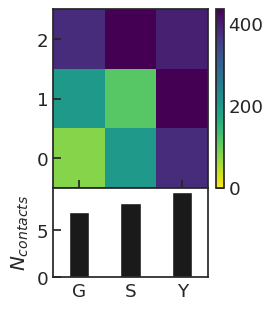

In [12]:
fig = plt.figure(figsize=(3.75,4))
gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,0.5])
ax0 = plt.subplot(gs[0,1])

im = ax0.imshow(n_contacts, cmap='viridis_r', \
                    vmin=0, aspect='auto', origin='lower')
divider = make_axes_locatable(ax0)
ax1 = divider.append_axes("bottom", size="50%", pad=0)
cax = divider.append_axes("right", size="5%", pad=0.08)
cb = plt.colorbar( im, ax=ax0, cax=cax )

ax1.set_xlim(-0.5, 2.5); 
ax1.set_xticks(range(3)); ax0.set_yticks(range(3))
ax1.set_xticklabels(['G', 'S', 'Y'])
    
ax1.bar(range(3), n_contacts_norm, color='k', width=0.4) 
ax1.set_ylabel('$N_{contacts}$')
plt.tight_layout()
plt.savefig("figures/contacts_gsy.png", dpi=300, transparent=True)

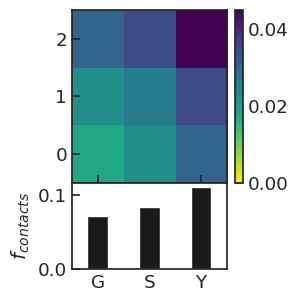

In [13]:
fig = plt.figure(figsize=(4,3.9))
gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,0.5])
ax0 = plt.subplot(gs[0,1])

im = ax0.imshow(f_contacts, cmap='viridis_r', \
                    vmin=0, vmax=0.045, aspect='auto', origin='lower')
divider = make_axes_locatable(ax0)
ax1 = divider.append_axes("bottom", size="50%", pad=0)
cax = divider.append_axes("right", size="5%", pad=0.08)
cb = plt.colorbar( im, ax=ax0, cax=cax )

ax1.set_xlim(-0.5, 2.5); 
ax1.set_xticks(range(3)); ax0.set_yticks(range(3))
ax1.set_xticklabels(['G', 'S', 'Y'])
    
ax1.bar(range(3), f_contacts_norm, color='k', width=0.4) 
ax1.set_ylabel('$f_{contacts}$')
plt.tight_layout()
plt.savefig("figures/contacts_gsy_norm.png", dpi=300, transparent=True)

## $\pi$-stacking

In [14]:
stacked = []
for i,pair in enumerate(list(itertools.combinations(TYR,2))):
    sel = np.logical_and(ring_dist[i] < 0.45, \
                        np.abs(angle_between_planes[i] - np.pi/2) > 1)
    if np.any(sel):
       atom_select = list([atom.index for atom in traj.top.residue(pair[0]).atoms]) + \
           list([atom.index for atom in traj.top.residue(pair[1]).atoms])
  #     #print (atom_select)
       stacked.append(traj[sel].atom_slice(atom_select))
stacked_all = md.join(stacked)
stacked_all.center_coordinates()
stacked_all.save("gsy_pistacked.gro")

NameError: name 'ring_dist' is not defined

In [15]:
# Get indexes for the first three atoms in the ring
CG = [x.index for x in list(traj.topology.atoms) \
       if (x.name=='CG' and x.residue.name =='TYR')]
CD1 = [x.index for x in list(traj.topology.atoms) \
       if (x.name=='CD1' and x.residue.name =='TYR')]
CD2 = [x.index for x in list(traj.topology.atoms) \
       if (x.name=='CD2' and x.residue.name =='TYR')]

In [16]:
list(zip(CG, CD1, CD2))[0]

(3397, 3398, 3407)

In [17]:
# Get vectors normal to the plane
normal = []
for i,j,k in list(zip(CG,CD1,CD2)):
    # calculate bond vectors
    displacements = md.compute_displacements(traj, [[i,j], [i,k]])

    # calculate normal vectors
    normal.append(unit_normal_vector(displacements[:,0,:], displacements[:,1,:]))

In [18]:
print (np.shape(normal[0]))
print (normal[0])
print ((normal[0]*normal[0]).sum(1))

(2237, 3)
[[ 0.42756575 -0.6568622   0.6210633 ]
 [ 0.4097854  -0.61057043  0.6777018 ]
 [ 0.45130482 -0.54095536  0.709712  ]
 ...
 [-0.3791376  -0.70714754  0.5968224 ]
 [-0.40197805 -0.8629345   0.30619887]
 [-0.60502565 -0.7406359   0.29223713]]
[1.        1.        0.9999999 ... 0.9999999 1.0000001 1.       ]


In [19]:
#  Get angle between vectors
angle_between_planes = []
for i,j in itertools.combinations(range(len(TYR)),2):
    angle_between_planes.append(np.arccos((normal[i]*normal[j]).sum(1)))

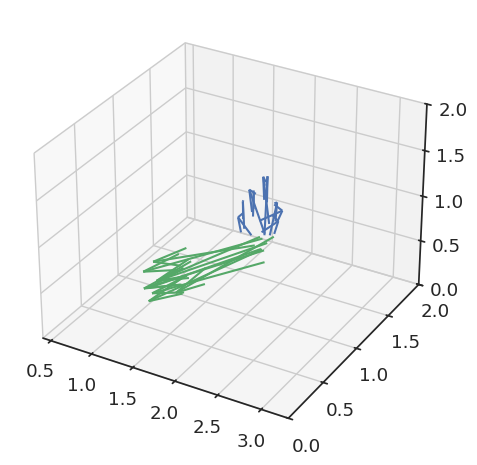

In [20]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(20):
    plt.quiver(traj.xyz[:,TYR[0]][i,0], traj.xyz[:,TYR[0]][i,1], traj.xyz[:,TYR[0]][i,2], \
               normal[0][i,0], normal[0][i,1], normal[0][i,2], color='b')
for i in range(20):
    plt.quiver(traj.xyz[:,TYR[1]][i,0], traj.xyz[:,TYR[1]][i,1], traj.xyz[:,TYR[1]][i,2], \
               normal[1][i,0], normal[1][i,1], normal[1][i,2], color='g')
ax.set_xlim(0.4); ax.set_ylim(0,2); ax.set_zlim(0,2)
plt.tight_layout()

In [21]:
ring_dist = []
for i,j in itertools.combinations(TYR,2):
    #print (list(traj.topology.residue(i).atoms))
    i_index =  [x.index for x in traj.topology.residue(i).atoms if
           x.name in ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ']] 
    j_index =  [x.index for x in traj.topology.residue(j).atoms if
           x.name in ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ']]
    ring_dist.append(np.mean(md.compute_distances(traj, list(itertools.product(i_index, j_index))), axis=1))

/tmp/ipykernel_185876/38881810.py:2: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  ax[0].plot(traj.time, ring_dist[2127], '.', label=list(itertools.combinations(TYR,2))[2127])


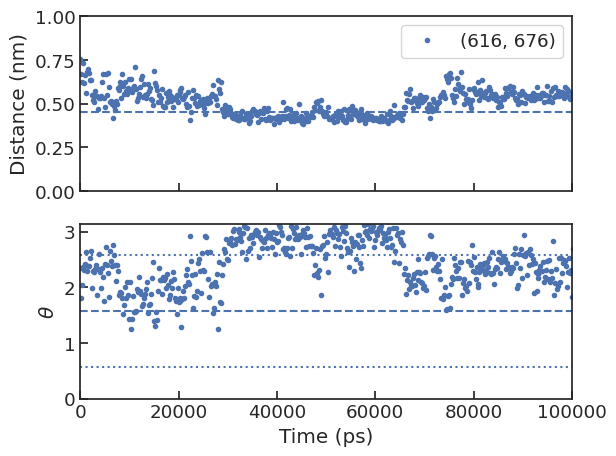

In [22]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(traj.time, ring_dist[2127], '.', label=list(itertools.combinations(TYR,2))[2127])
ax[0].axhline(0.45, 0, traj.time[-1], ls='--')
ax[0].set_ylabel('Distance (nm)')
ax[0].set_ylim(0,1)

ax[1].plot(traj.time, angle_between_planes[2127], '.')
ax[1].axhline(np.pi/2, 0, traj.time[-1], ls='--')
ax[1].axhline(np.pi/2-1, 0, traj.time[-1], ls='dotted')
ax[1].axhline(np.pi/2+1, 0, traj.time[-1], ls='dotted')
ax[1].set_ylim(0,np.pi)
ax[1].set_ylabel(r'$\theta$')
ax[1].set_xlabel('Time (ps)')

ax[0].set_xlim(0,1e5)
ax[0].legend()
plt.tight_layout()

In [23]:
stacked = []
for i,pair in enumerate(list(itertools.combinations(TYR,2))):
    sel = np.logical_and(ring_dist[i] < 0.45, \
                        np.abs(angle_between_planes[i] - np.pi/2) > 1)
    if np.any(sel):
       atom_select = list([atom.index for atom in traj.top.residue(pair[0]).atoms]) + \
           list([atom.index for atom in traj.top.residue(pair[1]).atoms])
  #     #print (atom_select)
       stacked.append(traj[sel].atom_slice(atom_select))
stacked_all = md.join(stacked)
stacked_all.center_coordinates()
stacked_all.save("gsy_pistacked.gro")

In [28]:
sel = np.array(ring_dist) < 0.65

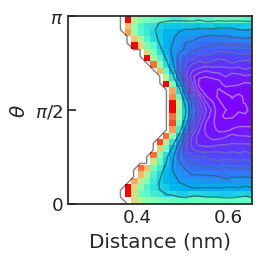

In [30]:
fig, ax = plt.subplots(figsize=(2.85, 2.85))
nbins=30
counts, xbins, ybins, image = ax.hist2d(np.array(ring_dist)[sel], np.array(angle_between_planes)[sel], \
                                        bins=(np.linspace(0.25, 0.65, nbins), np.linspace(0, np.pi, nbins)), \
                                        norm=LogNorm(), cmap='rainbow_r')
ax.contour(counts.T, levels=10, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], \
           linewidths=1, cmap='binary_r', alpha=0.5)

ax.set_yticks(np.linspace(0,np.pi,3)); ax.set_yticklabels([0, r"$\pi/2$", r"$\pi$"])        
ax.set_xlabel('Distance (nm)')
ax.set_ylabel(r'$\theta$')
plt.tight_layout()
plt.savefig("figures/gsy_pipi_dist.png", dpi=300, transparent=True)

### sp<sub>2</sub>-$\pi$

In [10]:
table, bonds = traj.topology.to_dataframe()
print (table.head())

   serial name element  resSeq resName  chainID segmentID
0       1  CH3       C       1     ACE        0          
1       2   H1       H       1     ACE        0          
2       3   H2       H       1     ACE        0          
3       4   H3       H       1     ACE        0          
4       5    C       C       1     ACE        0          


In [11]:
# Find atoms from carboxyl groups in peptide bonds
C = [x.index for x in list(traj.topology.atoms) \
       if (x.name=='C' and x.residue.name in ['GLY', 'SER', 'TYR'])]
O = [x.index for x in list(traj.topology.atoms) \
       if (x.name=='O' and x.residue.name in ['GLY', 'SER', 'TYR'])]
N = [traj.topology.atom(i+1).index for i in O]
    #[x.index for x in list(traj.topology.atoms) \
#       if (x.name=='CA' and x.residue.name in ['GLY', 'SER', 'TYR'])]

back = list(zip(C,O,N))
n_back = len(back)

In [12]:
bb_ring_dist = []
for i,j in itertools.product(range(n_back), range(nres[2])):
    i_index = back[i]
    j_index =  [x.index for x in traj.topology.residue(TYR[j]).atoms if
           x.name in ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ']]
    bb_ring_dist.append(np.median(md.compute_distances(traj, list(itertools.product(i_index, j_index))), axis=1))

In [13]:
# Get vectors normal to the bond plane
bond = []
for i,j,k in back:
    # calculate bond vectors
    displacements = md.compute_displacements(traj, [[i,j], [i,k]])
    # calculate normal vectors
    bond.append(unit_normal_vector(displacements[:,0,:], displacements[:,1,:]))

In [19]:
#  Get angle between vectors
angle_bond_ring = []
for i,j in itertools.product(range(n_back), range(nres[2])):
    angle_bond_ring.append(np.arccos((bond[i]*normal[j]).sum(1)))

In [20]:
sel = np.array(bb_ring_dist) < 0.65

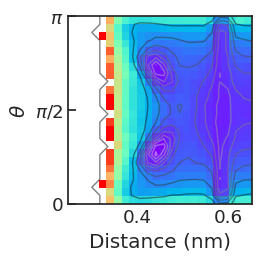

In [21]:
fig, ax = plt.subplots(figsize=(2.85, 2.85))
nbins=25
counts, xbins, ybins, image = ax.hist2d(np.array(bb_ring_dist)[sel], np.array(angle_bond_ring)[sel], \
                                        bins=(np.linspace(0.25,0.65,nbins), np.linspace(0,np.pi,nbins)), \
                                        norm=LogNorm(), cmap='rainbow_r')
ax.contour(counts.T, levels=10, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], \
           linewidths=1, cmap='binary_r', alpha=0.5)
#ax.axhline(3*np.pi/5, ls='--', color='k')
#ax.axhline(4*np.pi/5, ls='--', color='k')
ax.set_xlabel('Distance (nm)')
ax.set_ylabel(r'$\theta$')
ax.set_yticks(np.linspace(0,np.pi,3)); ax.set_yticklabels([0, r"$\pi/2$", r"$\pi$"])        
plt.tight_layout()
plt.savefig("figures/gsy_sp2pi_dist.png", dpi=300, transparent=True)

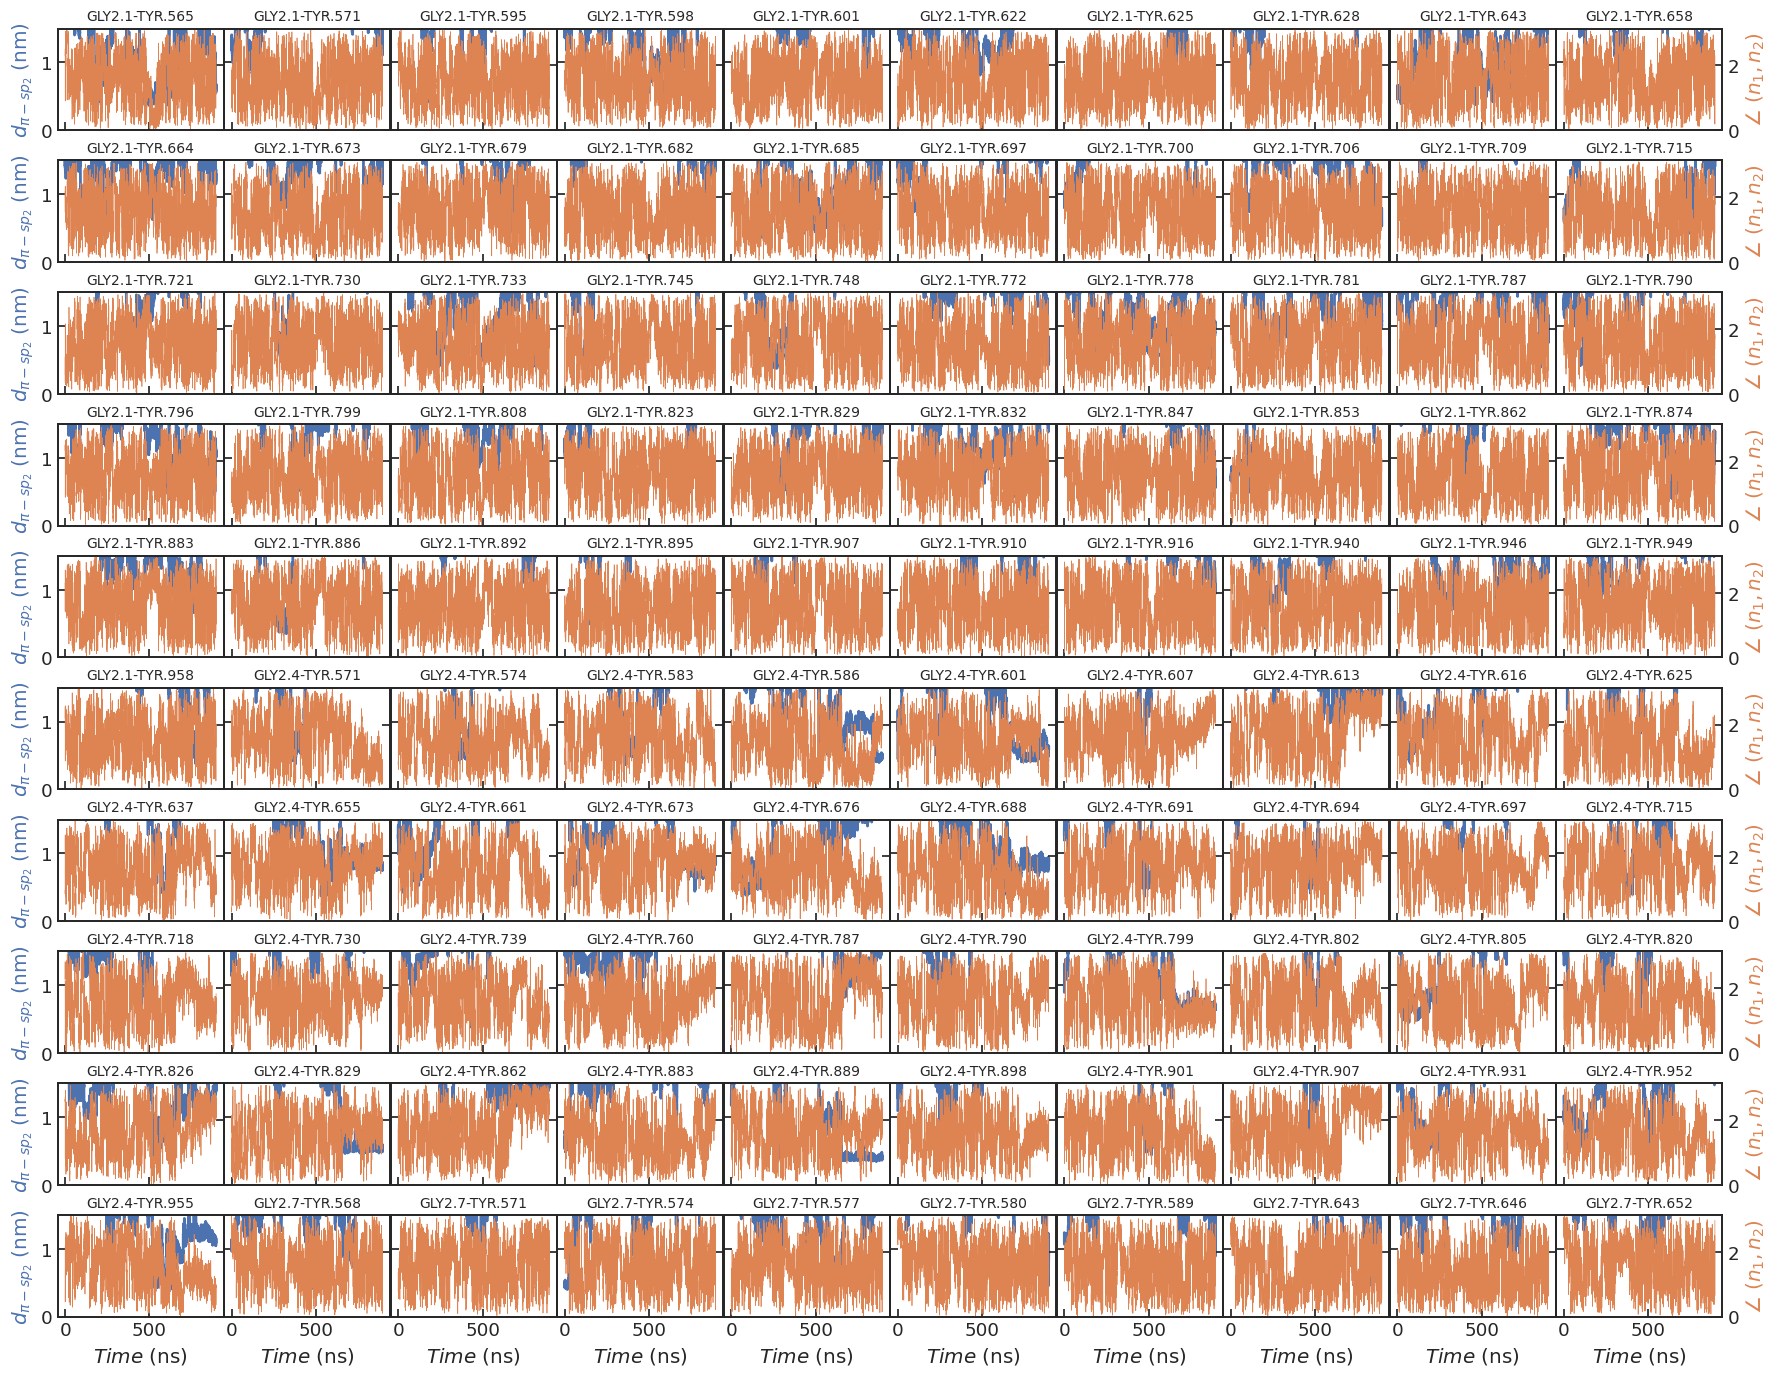

In [38]:
combinations = list(itertools.product(range(n_back), range(nres[2])))
count = 0

sel = np.array(bb_ring_dist) < 0.5

fig, ax = plt.subplots(10,10,figsize=(18,14), sharex=True, sharey=True)
ax = ax.flatten()
for i,s in enumerate(sel):
    if np.any(s):
        k,l = combinations[i]
        label = "%s.%i-TYR.%i"%(str(traj.topology.atom(back[k][0]).residue),traj.topology.atom(back[k][0]).residue.index, TYR[l])

        ax[count].plot(traj.time*1e-3, bb_ring_dist[i], lw=2)

        axt = ax[count].twinx()
        axt.plot(traj.time*1e-3, angle_bond_ring[i], c='C1', lw=0.5)
        axt.set_ylim(0, np.pi)
        ax[count].set_title(label, fontsize=10)

        count +=1
        if (count)%10 == 0:
            axt.set_ylabel(r'$\angle$ ($n_1,n_2$)', color='C1')
        else:
            axt.set_yticklabels([])

        if count == 100:
            break    


[ax[i*10].set_ylabel(r'$d_{\pi-sp_2}$ (nm)', color='C0') for i in range(10)]
[ax[-i-1].set_xlabel(r'$Time$ (ns)') for i in range(10)]
ax[-1].set_ylim(0,1.5)
plt.tight_layout(w_pad=0, h_pad=0)

In [154]:
stacked = []
sel = (np.array(bb_ring_dist) < 0.45) & (np.array(angle_bond_ring) < 4*np.pi/5) & (np.array(angle_bond_ring) > 3*np.pi/5)
for i,s in enumerate(sel): 
    if np.any(s):
        k,l = combinations[i]
        selsel = list(back[k]) + list([x.index for x in traj.topology.residue(TYR[l]).atoms])
        try:
            stacked.append(traj[s].atom_slice(selsel))
        except ValueError as e:
            print (e)
            print (k, back[k])
            print (l, list([x.index for x in traj.topology.residue(TYR[l]).atoms]))          
            label = "%s.%i-TYR.%i"%(str(traj.topology.atom(back[k][0]).residue),traj.topology.atom(back[k][0]).residue.index, TYR[l])
            print (label)
            print ()

ie = i

sel = (np.array(bb_ring_dist) < 0.45) & (np.array(angle_bond_ring) < 2*np.pi/5) & (np.array(angle_bond_ring) > 1*np.pi/5)
for i,s in enumerate(sel): 
    if np.any(s):
        k,l = combinations[i]
        selsel = list(back[k]) + list([x.index for x in traj.topology.residue(TYR[l]).atoms])
        try:
            stacked.append(traj[s].atom_slice(selsel))
        except ValueError as e:
            print (e)
            print (k, back[k])
            print (l, list([x.index for x in traj.topology.residue(TYR[l]).atoms]))          
            label = "%s.%i-TYR.%i"%(str(traj.topology.atom(back[k][0]).residue),traj.topology.atom(back[k][0]).residue.index, TYR[l])
            print (label)

        try:
            stacked_all = md.join(stacked, check_topology=False)
            stacked_all.save("stacked%i.gro"%(i+ie))
        except TypeError as e:
            print (e)

try:
    stacked_all = md.join(stacked, check_topology=False)
    stacked_all.superpose(reference=stacked[0])
    stacked_all.save("gsf_sp2pi_stacked.gro")

except TypeError as e:
    print (e)
    print()


xyz must be shape (Any, 22, 3). You supplied  (6, 24, 3)
189 (3439, 3440, 3441)
1 [3420, 3421, 3422, 3423, 3424, 3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440]
TYR2.568-TYR.568

xyz must be shape (Any, 22, 3). You supplied  (1, 24, 3)
191 (3499, 3500, 3501)
3 [3480, 3481, 3482, 3483, 3484, 3485, 3486, 3487, 3488, 3489, 3490, 3491, 3492, 3493, 3494, 3495, 3496, 3497, 3498, 3499, 3500]
TYR2.574-TYR.574

xyz must be shape (Any, 22, 3). You supplied  (2, 24, 3)
193 (3559, 3560, 3561)
5 [3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560]
TYR2.580-TYR.580

xyz must be shape (Any, 22, 3). You supplied  (1, 24, 3)
194 (3589, 3590, 3591)
6 [3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590]
TYR2.583-TYR.583

xyz must be shape (Any, 22, 3). You supplied  (4, 24, 3)
195 (3619, 3620, 3621)
7 [3600, 360

# GSF

In [22]:
xtc = "../data/soupF_XXL_amber99sb-star-ildn_tip3p_dense_npt_proc.xtc"
gro = "../data/soupF_XXL_amber99sb-star-ildn_tip3p_dense_npt_berendsen.gro"
traj = md.load_xtc(xtc, top=gro, stride=20)

In [23]:
GLY = [x.index for x in list(traj.topology.residues) \
       if (x.name=='GLY')] 
SER = [x.index for x in list(traj.topology.residues) \
       if (x.name=='SER')] 
PHE = [x.index for x in list(traj.topology.residues) \
       if (x.name=='PHE')]

nres = np.array([len(GLY), len(SER), len(PHE)])

## Contacts

In [8]:
ib = 100
# Find contacts for residue pairs 
# 0: Gly; 1: Ser; 2: Tyr
contact_map = {}
contact_map[0] = {}; contact_map[1] = {}; contact_map[2] = {}

contact_map[0][0] = md.compute_contacts(traj[ib:], \
                    contacts=list(itertools.combinations(GLY, 2)))    
contact_map[1][1] = md.compute_contacts(traj[ib:], \
                    contacts=list(itertools.combinations(SER, 2)))
contact_map[2][2] = md.compute_contacts(traj[ib:], \
                    contacts=list(itertools.combinations(PHE, 2)))
    
contact_map[0][1] = md.compute_contacts(traj[ib:], \
                    contacts=list(itertools.product(GLY, SER)))
contact_map[0][2] = md.compute_contacts(traj[ib:], \
                    contacts=list(itertools.product(GLY, PHE)))
contact_map[1][2] = md.compute_contacts(traj[ib:], \
                    contacts=list(itertools.product(SER, PHE)))

In [9]:
rcut = 0.6

# Calculate number contacts for residue pairs 
n_cont = np.zeros((3,3), dtype=np.int64)
for k in contact_map.keys():
    for l in contact_map[k].keys():
            for m, (i,j) in enumerate(contact_map[k][l][1]):   
                n_cont[k,l] += sum(contact_map[k][l][0][:,m] < rcut)
            if (l != k):
                n_cont[l,k] = n_cont[k,l]
lsim = len(traj[ib:]) # normalize by simulation length
n_contacts = np.int64(n_cont/lsim)

# Calculate normalized number contacts for residue pairs 
n_contacts_norm = np.sum(n_cont, axis=0)/nres/lsim

# Calculate fraction of contacts for residue pairs
# Divides number of contacts by number of pairs for each specific type
f_contacts = np.zeros((3,3), dtype=np.float64)
for k in contact_map.keys():
    for l in contact_map[k].keys():
        f_contacts[k,l] = n_cont[k,l]/(len(contact_map[k][l][1]))
        if (l != k):
            f_contacts[l,k] = f_contacts[k,l]
f_contacts = f_contacts/lsim
f_contacts_norm = np.sum(f_contacts, axis=0, dtype=np.float64)

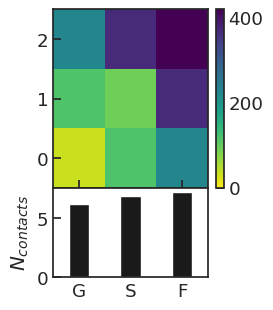

In [10]:
fig = plt.figure(figsize=(3.75,4))
gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,0.5])
ax0 = plt.subplot(gs[0,1])

im = ax0.imshow(n_contacts, cmap='viridis_r', \
                    vmin=0, aspect='auto', origin='lower')
divider = make_axes_locatable(ax0)
ax1 = divider.append_axes("bottom", size="50%", pad=0)
cax = divider.append_axes("right", size="5%", pad=0.08)
cb = plt.colorbar( im, ax=ax0, cax=cax )

ax1.set_xlim(-0.5, 2.5); 
ax1.set_xticks(range(3)); ax0.set_yticks(range(3))
ax1.set_xticklabels(['G', 'S', 'F'])
    
ax1.bar(range(3), n_contacts_norm, color='k', width=0.4) 
ax1.set_ylabel('$N_{contacts}$')
plt.tight_layout()
plt.savefig("figures/contacts_gsf.png", dpi=300, transparent=True)

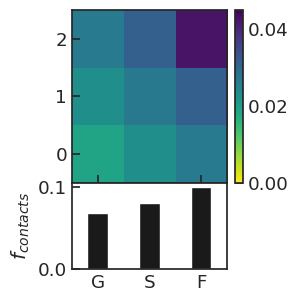

In [11]:
fig = plt.figure(figsize=(4,3.9))
gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,0.5])
ax0 = plt.subplot(gs[0,1])

im = ax0.imshow(f_contacts, cmap='viridis_r', \
                    vmin=0, vmax=0.045, aspect='auto', origin='lower')
divider = make_axes_locatable(ax0)
ax1 = divider.append_axes("bottom", size="50%", pad=0)
cax = divider.append_axes("right", size="5%", pad=0.08)
cb = plt.colorbar( im, ax=ax0, cax=cax )

ax1.set_xlim(-0.5, 2.5); 
ax1.set_xticks(range(3)); ax0.set_yticks(range(3))
ax1.set_xticklabels(['G', 'S', 'F'])
    
ax1.bar(range(3), f_contacts_norm, color='k', width=0.4) 
ax1.set_ylabel('$f_{contacts}$')
plt.tight_layout()
plt.savefig("figures/contacts_gsf_norm.png", dpi=300, transparent=True)

## $\pi$-stacking

In [24]:
# Get indexes for the first three atoms in the ring
CG = [x.index for x in list(traj.topology.atoms) \
       if (x.name=='CG' and x.residue.name =='PHE')]
CD1 = [x.index for x in list(traj.topology.atoms) \
       if (x.name=='CD1' and x.residue.name =='PHE')]
CD2 = [x.index for x in list(traj.topology.atoms) \
       if (x.name=='CD2' and x.residue.name =='PHE')]

In [25]:
# Get vectors normal to the plane
normal = []
for i,j,k in list(zip(CG,CD1,CD2)):
    # calculate bond vectors
    displacements = md.compute_displacements(traj, [[i,j], [i,k]])
    # calculate normal vectors
    normal.append(unit_normal_vector(displacements[:,0,:], displacements[:,1,:]))

In [14]:
#  Get angle between vectors
angle_between_planes = []
for i,j in itertools.combinations(range(len(PHE)),2):
    angle_between_planes.append(np.arccos((normal[i]*normal[j]).sum(1)))

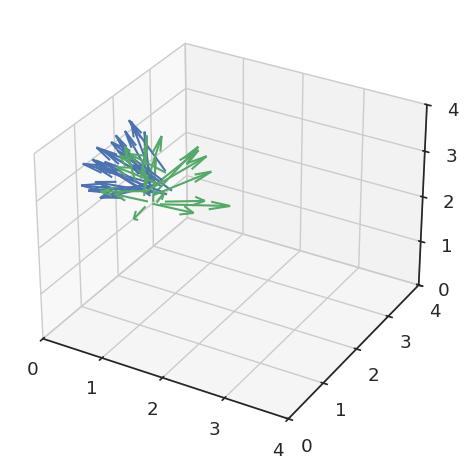

In [15]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(20):
    plt.quiver(traj.xyz[:,PHE[0]][i,0], traj.xyz[:,PHE[0]][i,1], traj.xyz[:,PHE[0]][i,2], \
               normal[0][i,0], normal[0][i,1], normal[0][i,2], color='b')
for i in range(20):
    plt.quiver(traj.xyz[:,PHE[1]][i,0], traj.xyz[:,PHE[1]][i,1], traj.xyz[:,PHE[1]][i,2], \
               normal[1][i,0], normal[1][i,1], normal[1][i,2], color='g')
ax.set_xlim(0,4); ax.set_ylim(0,4); ax.set_zlim(0,4)
plt.tight_layout()

In [16]:
ring_dist = []
for i,j in itertools.combinations(PHE,2):
    #print (list(traj.topology.residue(i).atoms))
    i_index =  [x.index for x in traj.topology.residue(i).atoms if
           x.name in ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ']] 
    j_index =  [x.index for x in traj.topology.residue(j).atoms if
           x.name in ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ']]
    ring_dist.append(np.mean(md.compute_distances(traj, list(itertools.product(i_index, j_index))), axis=1))

In [17]:
sel = np.array(ring_dist) < 0.65

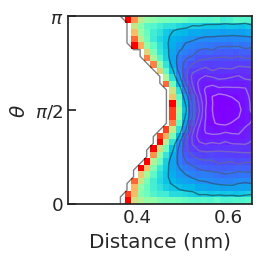

In [19]:
fig, ax = plt.subplots(figsize=(2.85, 2.85))
nbins=30
counts, xbins, ybins, image = ax.hist2d(np.array(ring_dist)[sel], np.array(angle_between_planes)[sel], \
                                        bins=(np.linspace(0.25,0.65,nbins), np.linspace(0,np.pi,nbins)), \
                                        norm=LogNorm(), cmap='rainbow_r')
ax.contour(counts.T, levels=10, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], \
           linewidths=1, cmap='binary_r', alpha=0.5)

ax.set_yticks(np.linspace(0,np.pi,3)); ax.set_yticklabels([0, r"$\pi/2$", r"$\pi$"])        
ax.set_xlabel('Distance (nm)')
ax.set_ylabel(r'$\theta$')
plt.tight_layout()
plt.savefig("figures/gsf_pipi_dist.png", dpi=300, transparent=True)

In [ ]:
stacked = []
for i,pair in enumerate(list(itertools.combinations(PHE,2))):
    sel = np.logical_and(ring_dist[i] < 0.45, \
                        np.abs(angle_between_planes[i] - np.pi/2) > 1)
    if np.any(sel):
       atom_select = list([atom.index for atom in traj.top.residue(pair[0]).atoms]) + \
           list([atom.index for atom in traj.top.residue(pair[1]).atoms])
  #     #print (atom_select)
       stacked.append(traj[sel].atom_slice(atom_select))
stacked_all = md.join(stacked)
stacked_all.center_coordinates()
stacked_all.save("gsf_pistacked.gro")

### sp<sub>2</sub>-$\pi$


In [26]:
table, bonds = traj.topology.to_dataframe()
print (table.head())

   serial name element  resSeq resName  chainID segmentID
0       1  CH3       C       1     ACE        0          
1       2   H1       H       1     ACE        0          
2       3   H2       H       1     ACE        0          
3       4   H3       H       1     ACE        0          
4       5    C       C       1     ACE        0          


In [27]:
# Find atoms from carboxyl groups in peptide bonds
C = [x.index for x in list(traj.topology.atoms) \
       if (x.name=='C' and x.residue.name in ['GLY', 'SER', 'PHE'])]
O = [x.index for x in list(traj.topology.atoms) \
       if (x.name=='O' and x.residue.name in ['GLY', 'SER', 'PHE'])]
N = [traj.topology.atom(i+1).index for i in O]
    #[x.index for x in list(traj.topology.atoms) \
#       if (x.name=='CA' and x.residue.name in ['GLY', 'SER', 'TYR'])]

back = list(zip(C,O,N))
n_back = len(back)

In [28]:
bb_ring_dist = []
for i,j in itertools.product(range(n_back), range(nres[2])):
    i_index = back[i]
    j_index =  [x.index for x in traj.topology.residue(PHE[j]).atoms if
           x.name in ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ']]
    bb_ring_dist.append(np.median(md.compute_distances(traj, list(itertools.product(i_index, j_index))), axis=1))
len(bb_ring_dist)

40326

In [29]:
# Get vectors normal to the bond plane
bond = []
for i,j,k in back:
    # calculate bond vectors
    displacements = md.compute_displacements(traj, [[i,j], [i,k]])
    # calculate normal vectors
    bond.append(unit_normal_vector(displacements[:,0,:], displacements[:,1,:]))
    
#  Get angle between vectors
angle_bond_ring = []
for i,j in itertools.product(range(n_back), range(nres[2])):
    angle_bond_ring.append(np.arccos((bond[i]*normal[j]).sum(1)))

/tmp/ipykernel_1438055/1550094739.py:12: RuntimeWarning: invalid value encountered in arccos
  angle_bond_ring.append(np.arccos((bond[i]*normal[j]).sum(1)))


In [30]:
sel = np.array(bb_ring_dist) < 0.65
np.shape(bb_ring_dist), np.shape(np.array(angle_bond_ring))

((40326, 2350), (40326, 2350))

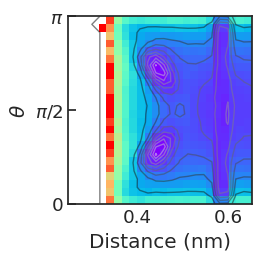

In [31]:
fig, ax = plt.subplots(figsize=(2.85, 2.85))
nbins=25
counts, xbins, ybins, image = ax.hist2d(np.array(bb_ring_dist)[sel], np.array(angle_bond_ring)[sel], \
                                        bins=(np.linspace(0.25,0.65,nbins), np.linspace(0,np.pi,nbins)), \
                                        norm=LogNorm(), cmap='rainbow_r')
ax.contour(counts.T, levels=10, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], \
           linewidths=1, cmap='binary_r', alpha=0.5)
ax.set_yticks(np.linspace(0,np.pi,3)); ax.set_yticklabels([0, r"$\pi/2$", r"$\pi$"])        
ax.set_xlabel('Distance (nm)')
ax.set_ylabel(r'$\theta$')
plt.tight_layout()
plt.savefig("figures/gsf_sp2pi_dist.png", dpi=300, transparent=True)



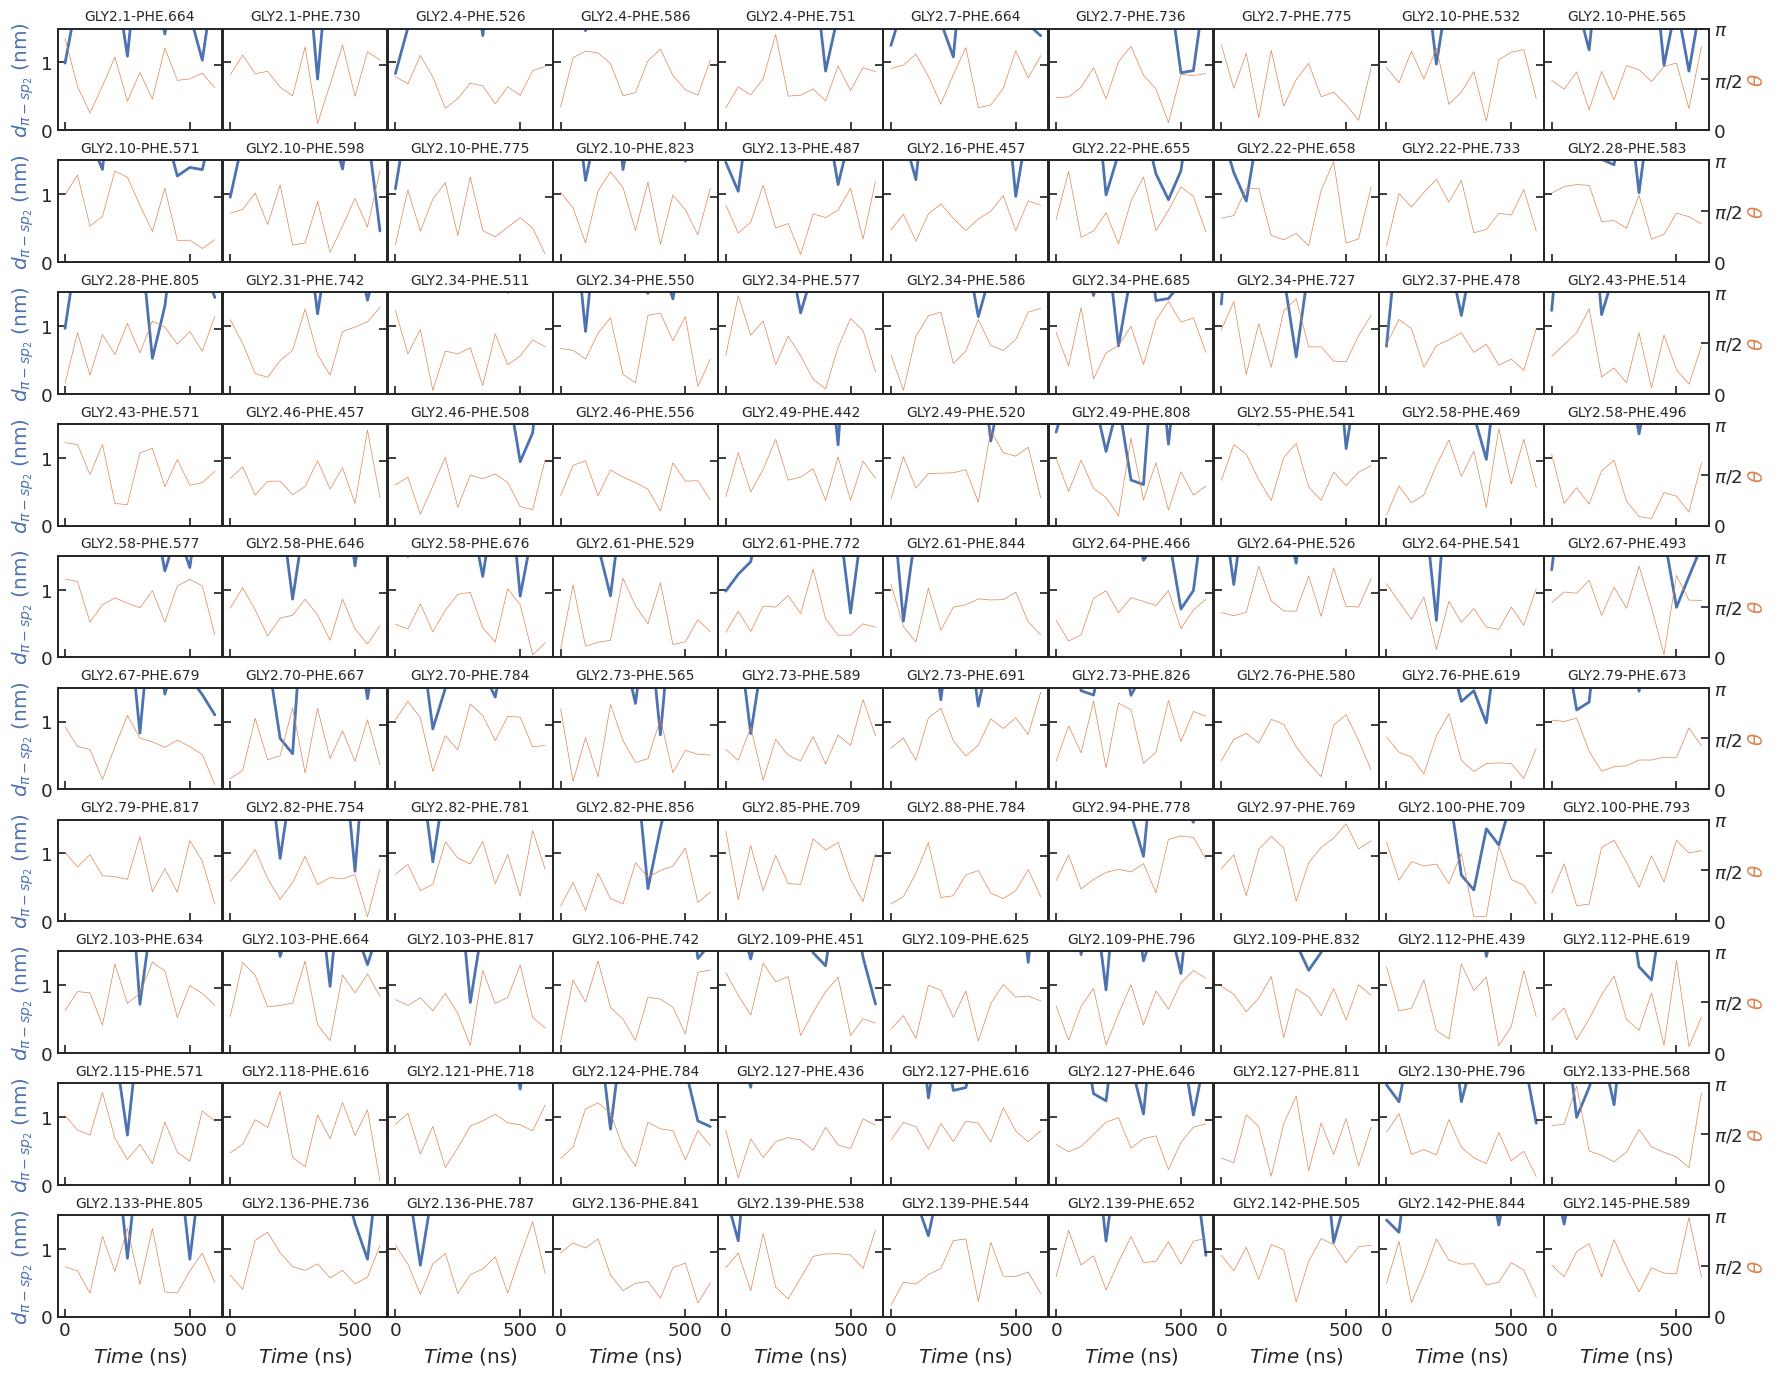

In [170]:
combinations = list(itertools.product(range(n_back), range(nres[2])))
count = 0

sel = np.array(bb_ring_dist) < 0.45

fig, ax = plt.subplots(10,10,figsize=(18,14), sharex=True, sharey=True)
ax = ax.flatten()
for i,s in enumerate(sel[100:,:]):
    if np.any(s):
        k,l = combinations[i]
        label = "%s.%i-PHE.%i"%(str(traj.topology.atom(back[k][0]).residue),traj.topology.atom(back[k][0]).residue.index, PHE[l])

        ax[count].plot(traj.time*1e-3, bb_ring_dist[i], lw=2)

        axt = ax[count].twinx()
        axt.plot(traj.time*1e-3, angle_bond_ring[i], c='C1', lw=0.5)
        axt.set_ylim(0, np.pi)
        ax[count].set_title(label, fontsize=10)

        count +=1
        if (count)%10 == 0:
            axt.set_yticks(np.linspace(0,np.pi,3)); axt.set_yticklabels([0, r"$\pi/2$", r"$\pi$"])
            axt.set_ylabel(r'$\theta$', color='C1')
        else:
            axt.set_yticklabels([])

        if count == 100:
            break    


[ax[i*10].set_ylabel(r'$d_{\pi-sp_2}$ (nm)', color='C0') for i in range(10)]
[ax[-i-1].set_xlabel(r'$Time$ (ns)') for i in range(10)]
ax[-1].set_ylim(0,1.5)
plt.tight_layout(w_pad=0, h_pad=0)

In [171]:
stacked = []
sel = (np.array(bb_ring_dist) < 0.45) & (np.array(angle_bond_ring) < 4*np.pi/5) & (np.array(angle_bond_ring) > 3*np.pi/5)
for i,s in enumerate(sel): 
    if np.any(s):
        k,l = combinations[i]
        selsel = list(back[k]) + list([x.index for x in traj.topology.residue(PHE[l]).atoms])
        try:
            stacked.append(traj[s].atom_slice(selsel))
        except ValueError as e:
            print (e)
            print (k, back[k])
            print (l, list([x.index for x in traj.topology.residue(PHE[l]).atoms]))          
            label = "%s.%i-PHE.%i"%(str(traj.topology.atom(back[k][0]).residue),traj.topology.atom(back[k][0]).residue.index, PHE[l])
            print (label)
            print ()

ie = i

sel = (np.array(bb_ring_dist) < 0.45) & (np.array(angle_bond_ring) < 2*np.pi/5) & (np.array(angle_bond_ring) > 1*np.pi/5)
for i,s in enumerate(sel): 
    if np.any(s):
        k,l = combinations[i]
        selsel = list(back[k]) + list([x.index for x in traj.topology.residue(PHE[l]).atoms])
        try:
            stacked.append(traj[s].atom_slice(selsel))
        except ValueError as e:
            print (e)
            print (k, back[k])
            print (l, list([x.index for x in traj.topology.residue(PHE[l]).atoms]))          
            label = "%s.%i-PHE.%i"%(str(traj.topology.atom(back[k][0]).residue),traj.topology.atom(back[k][0]).residue.index, PHE[l])
            print (label)

        try:
            stacked_all = md.join(stacked, check_topology=False)
            stacked_all.save("stacked%i.gro"%(i+ie))
        except TypeError as e:
            print (e)

try:
    stacked_all = md.join(stacked, check_topology=False)
    stacked_all.superpose(reference=stacked[0])
    stacked_all.save("gsf_sp2pi_stacked.gro")

except TypeError as e:
    print (e)
    print()


/home/david/anaconda3/lib/python3.12/site-packages/mdtraj/core/topology.py:84: UserWarning: atom_indices are not monotonically increasing
  warnings.warn("atom_indices are not monotonically increasing")
/home/david/anaconda3/lib/python3.12/site-packages/mdtraj/core/topology.py:86: UserWarning: atom_indices are not unique
  warnings.warn("atom_indices are not unique")


xyz must be shape (Any, 21, 3). You supplied  (1, 23, 3)
145 (2680, 2681, 2682)
0 [2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681]
PHE2.436-PHE.436

xyz must be shape (Any, 21, 3). You supplied  (3, 23, 3)
146 (2709, 2710, 2711)
1 [2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710]
PHE2.439-PHE.439

xyz must be shape (Any, 21, 3). You supplied  (2, 23, 3)
147 (2738, 2739, 2740)
2 [2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739]
PHE2.442-PHE.442

xyz must be shape (Any, 21, 3). You supplied  (2, 23, 3)
149 (2796, 2797, 2798)
4 [2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797]
PHE2.448-PHE.448

xyz must be shape (Any, 21, 3). You supplied  (1, 23, 3)
150 (2825, 2826, 2827)
5 [2807, 2808, 2809, 2810, 2811, 281

In [12]:
print()

## H - bonds

In [55]:
hbonds = md.baker_hubbard(traj, freq=0.01, periodic=False)

In [56]:
label = lambda hbond : '%s %i -- %s %i' % \
        (traj.topology.atom(hbond[0]).residue.name, \
        traj.topology.atom(hbond[0]).residue.index, \
        traj.topology.atom(hbond[2]).residue.name, \
        traj.topology.atom(hbond[2]).residue.index)

In [57]:
for hbond in hbonds[:10]:
    print(label(hbond))

GLY 4 -- SER 391
GLY 4 -- ACE 426
GLY 4 -- PHE 559
GLY 7 -- ACE 414
GLY 10 -- ACE 456
GLY 10 -- ACE 723
GLY 13 -- ACE 9
GLY 13 -- PHE 436
GLY 13 -- PHE 514
GLY 13 -- PHE 700


In [58]:
da_distances = md.compute_distances(traj, hbonds[:, [0,2]], periodic=False)

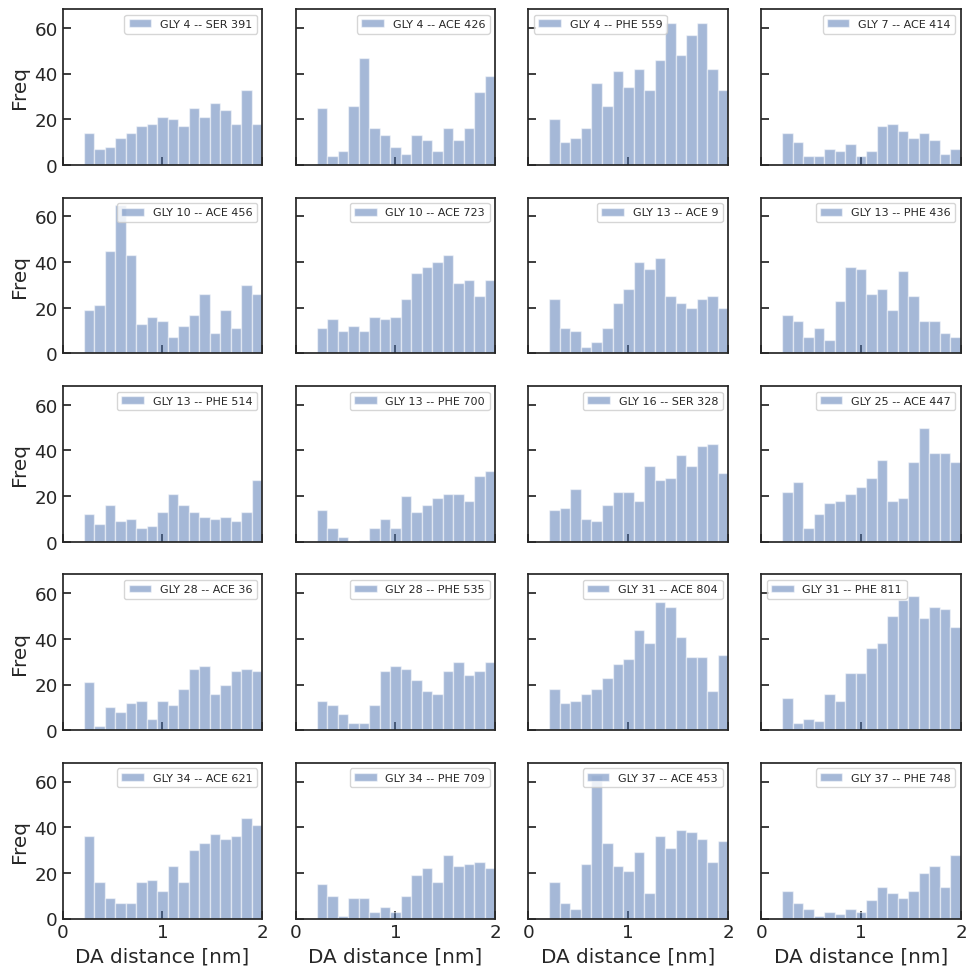

In [59]:
fig, ax = plt.subplots(5,4, figsize=(10,10), sharex=True, sharey=True)
ax = ax.flatten()
for i in range(20):
    ax[i].hist(da_distances[:, i], bins=np.linspace(0,2,20), \
               label=label(hbonds[i]), \
             alpha=0.5)
    ax[i].legend(fontsize=8)
[ax[4*i].set_ylabel('Freq') for i in range(5)]
[ax[-i].set_xlabel('DA distance [nm]') for i in range(1,5)]
ax[0].set_xlim(0,2)
plt.tight_layout()

(0.0, 2.0)

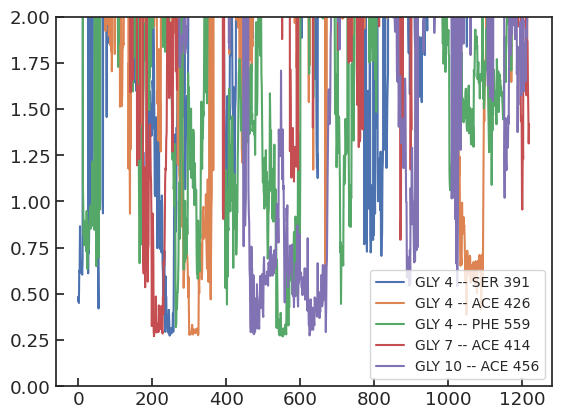

In [60]:
for i in range(5):
    plt.plot(da_distances[:, i], '-', ms=2, label=label(hbonds[i]))
plt.legend(fontsize=10)
plt.ylim(0,2)